Rubin LSST Product Basics Guide
Author: McAelan Remigio

This guide introduces the Rubin Science Platform LSST data products including:
1) How to use the LSST Science Pipelines, Environment, and Packages
2) Accessing the TAP Service/ADQL Interface
3) Exploring Metadata utilizing queries
4) Best Practices for Efficient Queries

In [1]:
 ! echo $IMAGE_DESCRIPTION
 ! eups list -s | grep lsst_distrib

Weekly 2025_22
lsst_distrib          gdfb3db0272+2ddfa09261 	current w_2025_22 w_latest setup


Important Python Packages to use (and includes LSST Science Pipelines)

In [3]:
import numpy
import matplotlib
import matplotlib.pyplot as plt
import pandas
from lsst.rsp import get_tap_service, retrieve_query
import lsst.daf.butler as dafButler
import lsst.geom
import lsst.afw.display as afwDisplay

print('numpy version: ', numpy.__version__)
print('matplotlib version: ', matplotlib.__version__)

numpy version:  2.0.2
matplotlib version:  3.10.3


Help Documentation for Packages 

In [5]:
# help(numpy)
# help(matplotlib)
# help(numpy.abs)
# help(matplotlib.pyplot)

# oh, and don't uncomment all of them at the same time, just do one, it can be really... really long.

Get Table Access Protocol (TAP) Service (its for ADQL)

In [6]:
service = get_tap_service("tap")

Exploring TAP Columns and Tables

In [7]:
# List of Table Names/Descriptions 
my_adql_query = "SELECT description, table_name FROM TAP_SCHEMA.tables"
results = service.search(my_adql_query)
results_table = results.to_table().to_pandas()
results_table

,description,table_name
0,Metadata about the 189 individual CCD images f...,dp02_dc2_catalogs.CcdVisit
1,Static information about the subset of tracts ...,dp02_dc2_catalogs.CoaddPatches
2,Properties of time-varying astronomical object...,dp02_dc2_catalogs.DiaObject
3,Properties of transient-object detections on t...,dp02_dc2_catalogs.DiaSource
4,Forced-photometry measurements on individual s...,dp02_dc2_catalogs.ForcedSource
5,Point-source forced-photometry measurements on...,dp02_dc2_catalogs.ForcedSourceOnDiaObject
6,Match information for TruthSummary objects.,dp02_dc2_catalogs.MatchesTruth
7,Properties of the astronomical objects detecte...,dp02_dc2_catalogs.Object
8,Properties of detections on the single-epoch v...,dp02_dc2_catalogs.Source
9,Summary properties of objects from the DESC DC...,dp02_dc2_catalogs.TruthSummary


In [8]:
# List of Column Names
my_adql_query = "SELECT * from TAP_SCHEMA.columns "+\
                 "WHERE table_name = 'dp02_dc2_catalogs.Object'"
res = service.search(my_adql_query)
print(res.fieldnames)

('"size"', 'arraysize', 'column_index', 'column_name', 'datatype', 'description', 'indexed', 'principal', 'std', 'table_name', 'ucd', 'unit', 'utype', 'xtype')


In [10]:
# Names, data types, description, units for all columns + count of columns
my_adql_query = "SELECT column_name, datatype, description, unit "+\
                 "FROM TAP_SCHEMA.columns "+\
                 "WHERE table_name = 'dp02_dc2_catalogs.Object'"
results = service.search(my_adql_query)
results_table = results.to_table().to_pandas()
print('Number of columns available in the Object catalog: ', len(results_table))

# display all table information
results_table

Number of columns available in the Object catalog:  991


,column_name,datatype,description,unit
0,coord_dec,double,Fiducial ICRS Declination of centroid used for...,deg
1,coord_ra,double,Fiducial ICRS Right Ascension of centroid used...,deg
2,deblend_nChild,int,Number of children this object has (defaults t...,
3,deblend_skipped,boolean,Deblender skipped this source,
4,detect_fromBlend,boolean,This source is deblended from a parent with mo...,
...,...,...,...,...
986,z_psfFlux_flag_apCorr,boolean,Set if unable to aperture correct base_PsfFlux...,
987,z_psfFlux_flag_edge,boolean,Object was too close to the edge of the image ...,
988,z_psfFlux_flag_noGoodPixels,boolean,Not enough non-rejected pixels in data to atte...,
989,z_psfFluxErr,double,Flux uncertainty derived from linear least-squ...,nJy


In [11]:
# Only displaying names/descriptions matching your string (like a filter) to see relevant columns 
my_string = 'cModelFlux'
for col,des in zip(results_table['column_name'],results_table['description']):
     if col.find(my_string) > -1:
         print('%-40s %-200s' % (col,des))

# examples could also be something like "extendedness", "deblend", or "detect"

g_cModelFlux                             Flux from the final cmodel fit. Forced on g-band.                                                                                                                                                       
g_cModelFlux_inner                       Flux within the fit region, with no extrapolation. Forced on g-band.                                                                                                                                    
g_cModelFluxErr                          Flux uncertainty from the final cmodel fit. Forced on g-band.                                                                                                                                           
g_free_cModelFlux                        Flux from the final cmodel fit. Measured on g-band.                                                                                                                                                     
g_free_cModelFlux_flag          

Retrieving Data with TAP 

To ensure fast and efficient queries when working with the LSST database via Qserv, follow these tips:

Use RA/Dec Constraints
- Qserv shards data by sky coordinates (RA, Dec).
- Including RA and Dec constraints in your query **avoids full-catalog scans**.
- Example: `WHERE ra BETWEEN ... AND ... AND dec BETWEEN ... AND ...`

Limit Rows for Exploration
- Use `SELECT TOP 10` or `maxrec=10` to **limit results** when exploring.
- This speeds up queries and prevents overload when not using a `WHERE` clause.

Filter on `detect_isPrimary = True`
- Recommended for `Object`, `Source`, and `ForcedSource` catalogs.
- Ensures:
  - No child (deblended) sources are included.
  - Only sources in inner regions of coadd patches and tracts are returned.
  - Excludes detections in pseudo-filters.
- Helps eliminate duplicates and improves scientific reliability

Converting Fluxes to Magnitude

Converting Fluxes to Magnitudes (AB System)

The LSST `Object` and `Source` catalogs store **fluxes** (not magnitudes) to save space. All fluxes are in **nanojanskys (nJy)**.

Flux to AB Magnitude Conversion
Use the following formula to convert flux to AB magnitudes:
\[
m_{AB} = -2.5 \log_{10}(f_{nJy}) + 31.4
\]

In Python (after retrieving flux columns)
```python
results_table['r_calibMag'] = -2.5 * numpy.log10(results_table['r_calibFlux']) + 31.4
results_table['r_cModelMag'] = -2.5 * numpy.log10(results_table['r_cModelFlux']) + 31.4

Searches

10 Objects

PLEASE specify a region or a maximum number of records, the Object catalog contains hundreds of MILLIONS or rows and results
It can take a long time, return too many rows, go infinitely, or crash

example: maxrec = 10 in service.search() or SELECT TOP 10 in ADQL query will only get 10 objects. 

Using maxrec might return a DALOverflowWarning that lets the user know partial results were returned even if they were desired '


10,000 Point-Like Objects

We can also do Top 10000 comfortably if they're points and not objects

Example: Retrieving g-, r- and i-band magnitudes for 10000 objects that are likely to be stars

In [19]:
use_center_coords = "62, -37"

results = service.search("SELECT TOP 10000 "
                         "coord_ra, coord_dec, "
                         # remember that nanojansky (nJy) is a unit of flux density used to measure the brightness 
                         # 1 nJy = 10^-9 Jy and can also be used to measure radio sources
                         "scisql_nanojanskyToAbMag(g_calibFlux) as g_calibMag, " # g- band magnitude
                         "scisql_nanojanskyToAbMag(r_calibFlux) as r_calibMag, " # r- band magnitude 
                         "scisql_nanojanskyToAbMag(i_calibFlux) as i_calibMag, " # i- band magnitude
                         "scisql_nanojanskyToAbMagSigma(g_calibFlux, g_calibFluxErr) as g_calibMagErr "
                         "FROM dp02_dc2_catalogs.Object "
                         "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "
                         "CIRCLE('ICRS', "+use_center_coords+", 1.0)) = 1 "
                         "AND detect_isPrimary = 1 "
                         "AND g_calibFlux > 360 "
                         "AND r_calibFlux > 360 "
                         "AND i_calibFlux > 360 "
                         "AND g_extendedness = 0 "
                         "AND r_extendedness = 0 "
                         "AND i_extendedness = 0")

results_table = results.to_table()
print(len(results_table))
# results_table
data = results_table.to_pandas()
data

10000


,coord_ra,coord_dec,g_calibMag,r_calibMag,i_calibMag,g_calibMagErr
0,62.918587,-37.594073,24.062321,22.777854,21.883390,0.041075
1,62.992458,-37.591102,21.323185,20.788576,20.586048,0.003814
2,62.901532,-37.597110,24.255068,23.018709,21.790380,0.047455
3,62.726709,-37.596187,19.079459,17.829852,17.084546,0.000562
4,62.915217,-37.595247,22.955373,21.745076,20.918189,0.014791
...,...,...,...,...,...,...
9995,61.144459,-37.341439,17.833759,17.557046,17.464246,0.000249
9996,61.274697,-37.333102,23.503109,22.292734,21.660146,0.023749
9997,61.301937,-37.333499,24.982051,24.192133,23.873974,0.092279
9998,61.236104,-37.333163,20.636776,20.204744,20.028548,0.001998


In [20]:
data.columns
data['coord_ra']
data['coord_ra'].values

array([62.9185866, 62.9924575, 62.9015322, ..., 61.301937 , 61.2361037,
       61.1632874])

Color-Magnitude Diagram 

The matplotlib.pyplot package (plt) will be used to generate plots

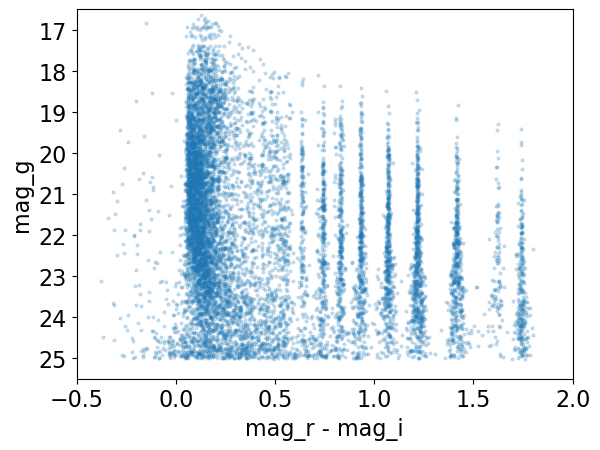

In [22]:
plt.plot(data['r_calibMag'].values - data['i_calibMag'].values,
         data['g_calibMag'].values, 'o', ms=2, alpha=0.2)

plt.xlabel('mag_r - mag_i', fontsize=16) # the x value
plt.ylabel('mag_g', fontsize=16) # the y value 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim([-0.5, 2.0]) # the range of where x starts and ends on the plot
plt.ylim([25.5, 16.5]) # the range of where y starts and ends on the plot

plt.show()

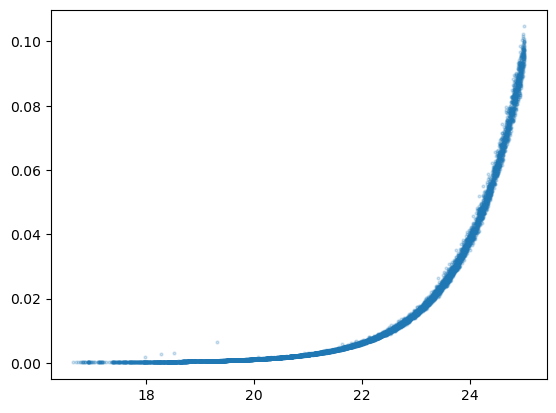

In [23]:
plt.plot(data['g_calibMag'].values, data['g_calibMagErr'].values, 'o', ms=2, alpha=0.2)
plt.show()

This is an example of how we would measure the photometric quality with uncertainty (error) and the object brightness
where bright objects (small magnitude values) have lower errors, but the dimmer it gets, the larger the unvertainty gets

In [ ]:
Image Data 

DP0 2 most common types of images

1) calexp - a single image in a single filter 
2) deepCoadd - a combination of single images into a deep stack or Coadd, where coadd is the combination of multiple image frames or
data points that is visualized into a single improved image or dataset

LSST Science Pipelines Images Storage

Images are stored into 2 places
1) tract - a portion of sky within the LSST all-sky tessellation (in other words, the sky map), divided into patches
2) patch - a quadrilaterial sub-region of a tract, a size that fits easily into memory on desktop computers/laptops like ours 

To retrieve and display a certain image at the desirted coordinate, specify the following

1) Image Type
2) Tract
3) Patch 

The Butler/Documentation for LSST

Fetches LSST data without needing to know its location or format, can be used to explore and discover what data exists

In [25]:
# an instance of the butler using DP0.2 configuration and collection
butler = dafButler.Butler('dp02', collections='2.2i/runs/DP0.2')
butler
# returns an informative statement about credentials being found

Identifying and Retrieving a deepCoadd

An example would be retrieving DC2 galaxy cluster and its sky map from the butler

example: RA = 03h42m59.0s, Dec = -32d16m09s (in degrees, 55.745834, -32.269167) is the location of a DC2 galaxy cluster

In [30]:
# we will be using lsst.geom to define a SpherePoint for the cluster's coordinates
my_ra_deg = 55.745834
my_dec_deg = -32.269167

my_spherePoint = lsst.geom.SpherePoint(my_ra_deg*lsst.geom.degrees,
                                       my_dec_deg*lsst.geom.degrees)
print(my_spherePoint)

# Identifying the tract and patch for the cluster's coordinates
skymap = butler.get('skyMap')

tract = skymap.findTract(my_spherePoint)
patch = tract.findPatch(my_spherePoint)

my_tract = tract.tract_id
my_patch = patch.getSequentialIndex()

print('my_tract: ', my_tract)
print('my_patch: ', my_patch)

# using the butler to retrieve the deep i-band Coadd for the tract and patch
dataId = {'band': 'i', 'tract': my_tract, 'patch': my_patch}
my_deepCoadd = butler.get('deepCoadd', dataId=dataId)
print(my_deepCoadd)

(55.7458340000, -32.2691670000)
my_tract:  4431
my_patch:  17


Displaying the Image with afwDisplay

(np.float64(11899.5),
 np.float64(16099.5),
 np.float64(7899.5),
 np.float64(12099.5))

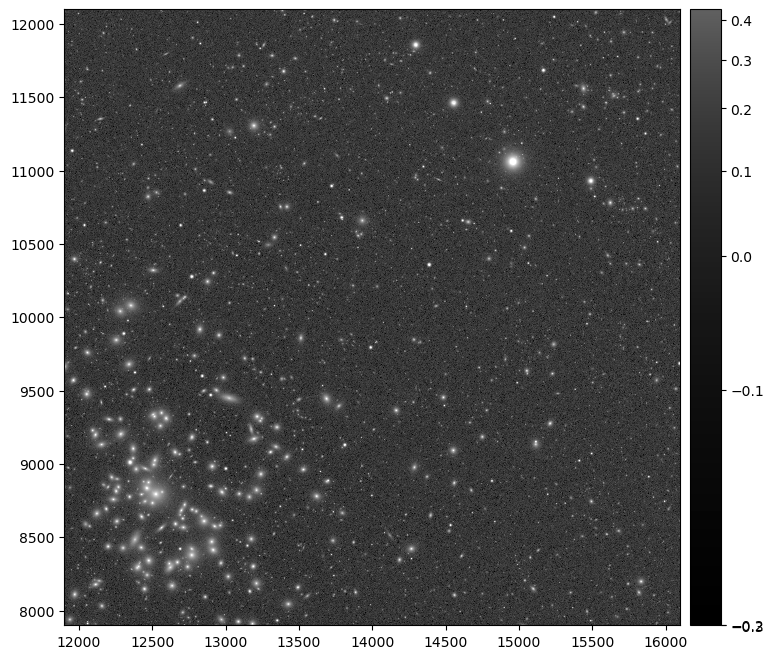

In [31]:
afwDisplay.setDefaultBackend('matplotlib')

# this creates a matplotlib.pyplot figure, graphs the thing basically in a way that image data can be represented
fig = plt.figure(figsize=(10, 8))
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(my_deepCoadd.image)
plt.gca().axis('on')

In [ ]:
# help(afw_display.scale) 
# help(afw_display.mtv) 

# for information about the packages, in general use the help function ^^